In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from keras.datasets import mnist
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

/Users/janburakowski/anaconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading the data
I load the MNIST dataset and normalize the pixel values to be between -1 and 1 because I am going to use Tanh as an activation function. Then I split the dataset to train and test sets.

In [2]:
(trainX, _), (_, _) = mnist.load_data()

trainX = (trainX.astype(np.float32) - 127.5) / 127.5

trainX = trainX.reshape(-1, 28*28)

train_tensor = torch.tensor(trainX)

train_dataset = TensorDataset(train_tensor, torch.zeros(len(train_tensor)))
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)


## Generator
I rewrite the architecture described in the paper in PyTorch (“We trained a multilayer perceptron with 100 input units, two hidden layers of 1200 ReLU units each, and an output layer with 784 sigmoid units.”), where I initialize the pass by creating a noise vector. I use Tanh function instead of Sigmoid for stability (inspired by - __[link to the blog post on towardsdatascience](https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739/)__ )

In [3]:

class Generator(nn.Module):
    def __init__(self, noise_dim=100):
        super(Generator, self).__init__()
        self.hidden1 = nn.Linear(noise_dim, 1200)
        self.hidden2 = nn.Linear(1200, 1200)
        self.output = nn.Linear(1200, 784)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, z):
        x = self.relu(self.hidden1(z))
        x = self.relu(self.hidden2(x))
        x = self.tanh(self.output(x))
        return x

## Discriminator
For the discriminator I also rewrite te architecture from the architecture, with a slight change - LeakyReLU instead of maxout to avoid the vanishing gradient problem.

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.hidden1 = nn.Linear(784, 240)
        self.hidden2 = nn.Linear(240, 240)
        self.output = nn.Linear(240, 1)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.leaky_relu(self.hidden1(x))
        x = self.leaky_relu(self.hidden2(x))
        x = self.sigmoid(self.output(x))
        return x

## Initialization
Preparing the Discriminator and Generator for training, choosing Binary Cross Entropy Loss (as the task of training is condensed to predicting between real and fake labels) and choosing Stochastic Gradient Descent as in the paper.

In [5]:
device = torch.device("cpu")
G = Generator(noise_dim=100).to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()
optimD = optim.SGD(D.parameters(), lr = 0.1, momentum = 0.5)
optimG = optim.SGD(G.parameters(), lr = 0.1, momentum = 0.5)

## Training Loop
Resembling the minmax game in the paper at each training step, we are taking real image from the dataset passing it through the discriminator with the goal of label 1. Next we generate a fake image through the generator and give it to the discriminator with the goal of label 0. Then we adjust the weights accordingly. For the generator we pass the noise and see if generated image can be distinguished from fake by the discriminator, and adjust the weights based on how well we full the discriminator. 

In [6]:
def training(real_label = 1.0, fake_label = 0.0, num_epochs = 50, batch_size = 100):
    for epoch in range(1, num_epochs + 1):
        for batch_idx, (real_images, _) in enumerate(train_loader):
            real_images = real_images.to(device)
    
            #discriminator training
            optimD.zero_grad()
            real_images_flat = real_images.view(real_images.size(0), -1)
            output_real = D(real_images_flat)
            labels_real = torch.full((real_images.size(0), 1), real_label, device=device)
            loss_real = criterion(output_real, labels_real)
    
            noise = torch.randn(real_images.size(0), 100, device=device)
            fake_images = G(noise).detach()
            output_fake = D(fake_images)
            labels_fake = torch.full((real_images.size(0), 1), fake_label, device=device)
            loss_fake = criterion(output_fake, labels_fake)
    
            lossD = (loss_real + loss_fake) / 2
            lossD.backward()
            optimD.step()
    
            #generator training
            optimG.zero_grad()
            noise = torch.randn(real_images.size(0), 100, device=device)
            fake_images = G(noise)
            output_fake_for_G = D(fake_images)
            labels_for_G = torch.full((real_images.size(0), 1), real_label, device=device)
            lossG = criterion(output_fake_for_G, labels_for_G)
            lossG.backward()
            optimG.step()
    
        print(f"Epoch {epoch}: D_loss={lossD.item():.4f}, G_loss={lossG.item():.4f}")
    
        if epoch % 5 == 0:
            z = torch.randn(16, 100, device=device)
            fake_images = G(z)
            fake_images = fake_images.view(-1, 28, 28).cpu().detach()
    
            fig, axes = plt.subplots(4, 4, figsize=(6,6))
            for i, ax in enumerate(axes.flat):
                ax.imshow(fake_images[i], cmap='gray')
                ax.axis('off')
            plt.suptitle(f"Generated Images after Epoch {epoch}", fontsize=14)
            plt.show()

Epoch 1: D_loss=0.6323, G_loss=1.4376
Epoch 2: D_loss=0.8162, G_loss=8.1249
Epoch 3: D_loss=0.4318, G_loss=3.6442
Epoch 4: D_loss=50.0000, G_loss=0.0000
Epoch 5: D_loss=50.0000, G_loss=0.0000


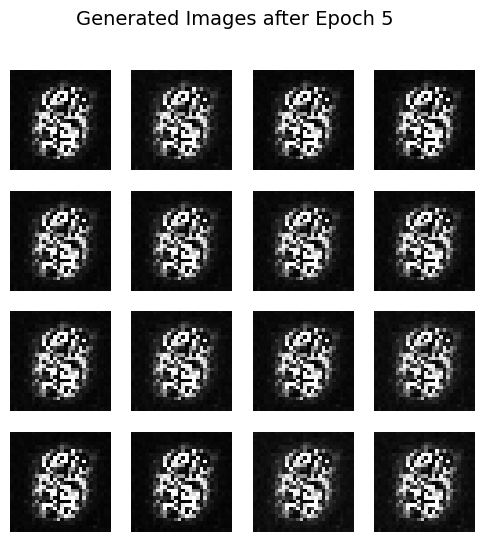

Epoch 6: D_loss=50.0000, G_loss=0.0000
Epoch 7: D_loss=50.0000, G_loss=0.0000
Epoch 8: D_loss=50.0000, G_loss=0.0000
Epoch 9: D_loss=50.0000, G_loss=0.0000
Epoch 10: D_loss=50.0000, G_loss=0.0000


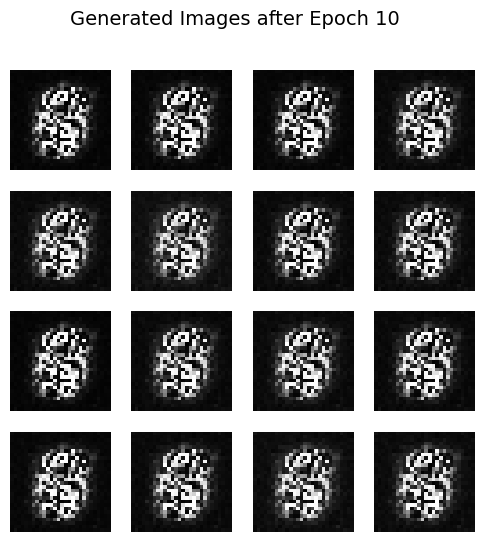

In [7]:
training(num_epochs = 10)

## I have encountered mode colapse
to resolve this without changing the architecture I have tried lowering the learning rate (because of this post I have found __[ in this blog post](https://neptune.ai/blog/gan-failure-modes?utm_source=chatgpt.com)__

Epoch 1: D_loss=0.4988, G_loss=0.6729
Epoch 2: D_loss=0.4076, G_loss=0.6807
Epoch 3: D_loss=0.3831, G_loss=0.6838
Epoch 4: D_loss=0.3835, G_loss=0.6664
Epoch 5: D_loss=0.3943, G_loss=0.6452


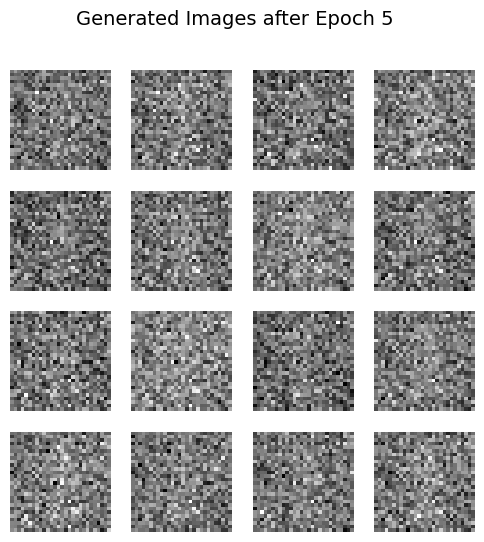

Epoch 6: D_loss=0.4071, G_loss=0.6355
Epoch 7: D_loss=0.4109, G_loss=0.6438
Epoch 8: D_loss=0.4128, G_loss=0.6653
Epoch 9: D_loss=0.4106, G_loss=0.6913
Epoch 10: D_loss=0.4092, G_loss=0.7089


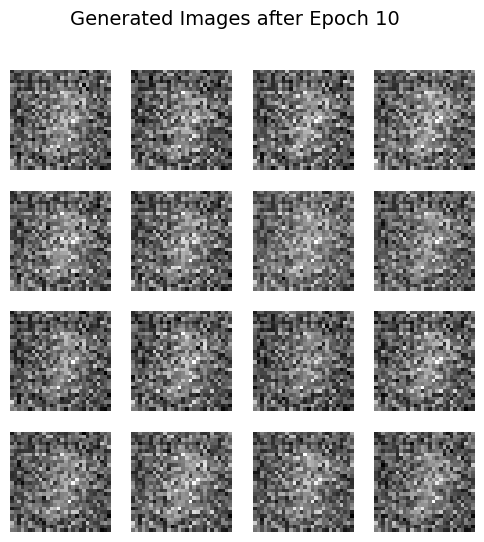

Epoch 11: D_loss=0.4233, G_loss=0.7136
Epoch 12: D_loss=0.4338, G_loss=0.7154
Epoch 13: D_loss=0.4551, G_loss=0.7030
Epoch 14: D_loss=0.4765, G_loss=0.6906
Epoch 15: D_loss=0.4914, G_loss=0.6932


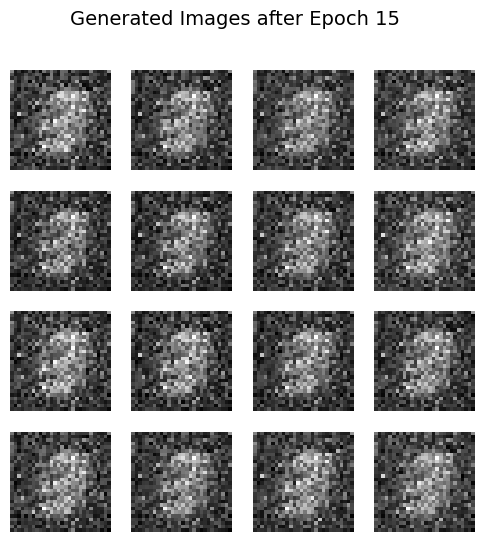

Epoch 16: D_loss=0.5140, G_loss=0.6878
Epoch 17: D_loss=0.5351, G_loss=0.6830
Epoch 18: D_loss=0.5531, G_loss=0.6828
Epoch 19: D_loss=0.5580, G_loss=0.6863
Epoch 20: D_loss=0.5665, G_loss=0.7029


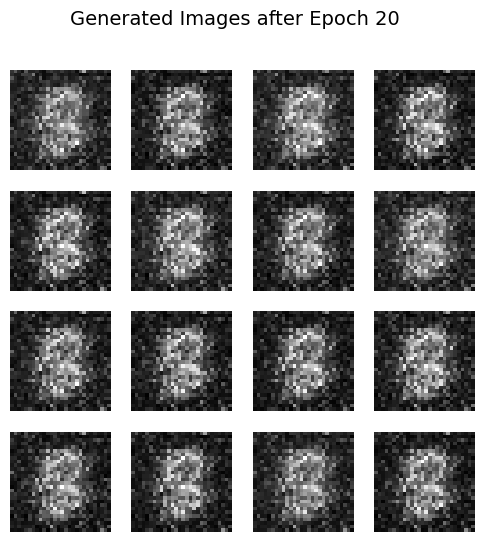

Epoch 21: D_loss=0.5704, G_loss=0.7103
Epoch 22: D_loss=0.5750, G_loss=0.7164
Epoch 23: D_loss=0.5811, G_loss=0.7283
Epoch 24: D_loss=0.5832, G_loss=0.7301
Epoch 25: D_loss=0.5733, G_loss=0.7479


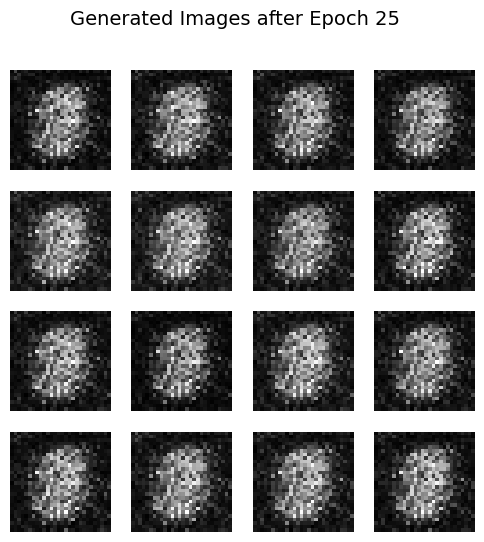

Epoch 26: D_loss=0.5597, G_loss=0.7716
Epoch 27: D_loss=0.5499, G_loss=0.7971
Epoch 28: D_loss=0.5401, G_loss=0.8133
Epoch 29: D_loss=0.5337, G_loss=0.8248
Epoch 30: D_loss=0.5218, G_loss=0.8462


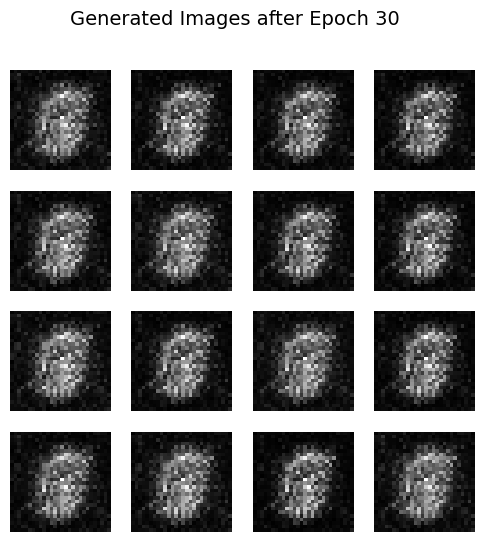

Epoch 31: D_loss=0.5097, G_loss=0.8680
Epoch 32: D_loss=0.4913, G_loss=0.8919
Epoch 33: D_loss=0.4687, G_loss=0.9346
Epoch 34: D_loss=0.4605, G_loss=0.9707
Epoch 35: D_loss=0.4346, G_loss=1.0070


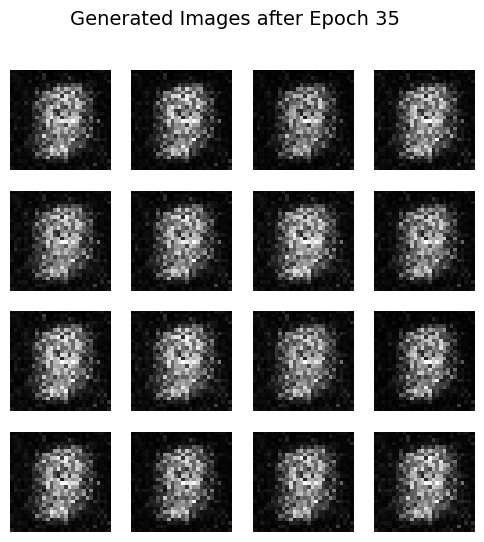

Epoch 36: D_loss=0.4108, G_loss=1.0428
Epoch 37: D_loss=0.3778, G_loss=1.1198
Epoch 38: D_loss=0.3600, G_loss=1.1648
Epoch 39: D_loss=0.3315, G_loss=1.2314
Epoch 40: D_loss=0.3140, G_loss=1.3173


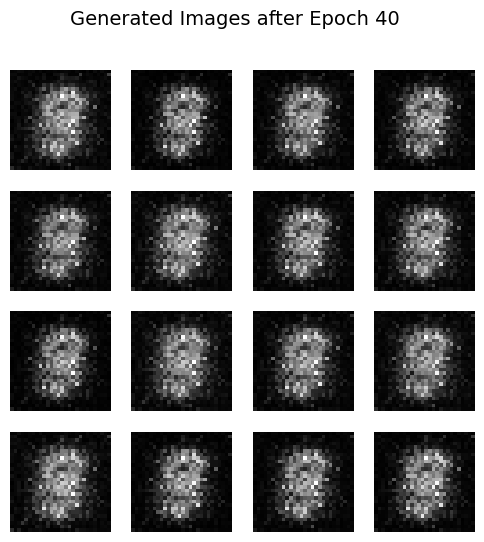

Epoch 41: D_loss=0.3012, G_loss=1.3612
Epoch 42: D_loss=0.2067, G_loss=1.6373
Epoch 43: D_loss=0.3675, G_loss=1.2206
Epoch 44: D_loss=0.2688, G_loss=1.4259
Epoch 45: D_loss=0.2226, G_loss=1.5861


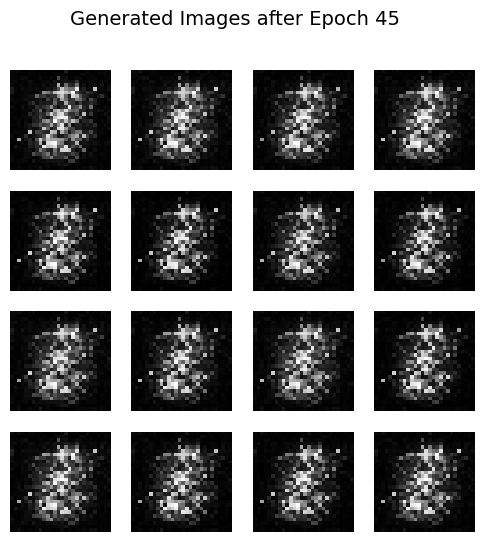

Epoch 46: D_loss=0.2332, G_loss=1.5452
Epoch 47: D_loss=0.2055, G_loss=1.6162
Epoch 48: D_loss=0.2730, G_loss=1.5539
Epoch 49: D_loss=0.2011, G_loss=1.7081
Epoch 50: D_loss=0.1833, G_loss=1.7127


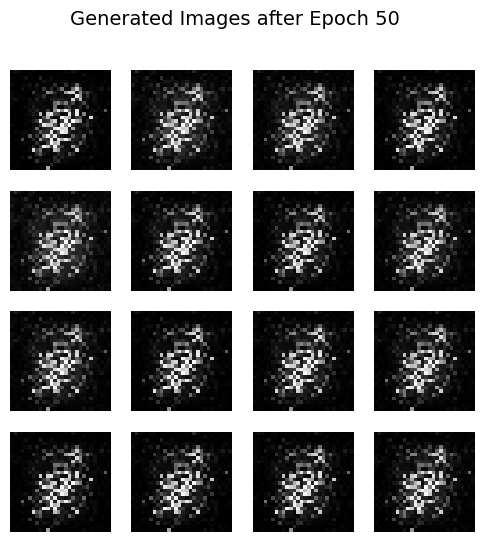

In [9]:
device = torch.device("cpu")
G = Generator(noise_dim=100).to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()
optimD = optim.SGD(D.parameters(), lr = 0.0002, momentum = 0.5)
optimG = optim.SGD(G.parameters(), lr = 0.0002, momentum = 0.5)

training(num_epochs = 50)

## I still encountered the mode colapse
So I have decided to try the optimizer I was more familiar form recent projects

Epoch 1: D_loss=0.6382, G_loss=0.9063
Epoch 2: D_loss=0.4122, G_loss=2.0947
Epoch 3: D_loss=0.4139, G_loss=1.5611
Epoch 4: D_loss=0.4885, G_loss=1.8392
Epoch 5: D_loss=0.4791, G_loss=1.6324


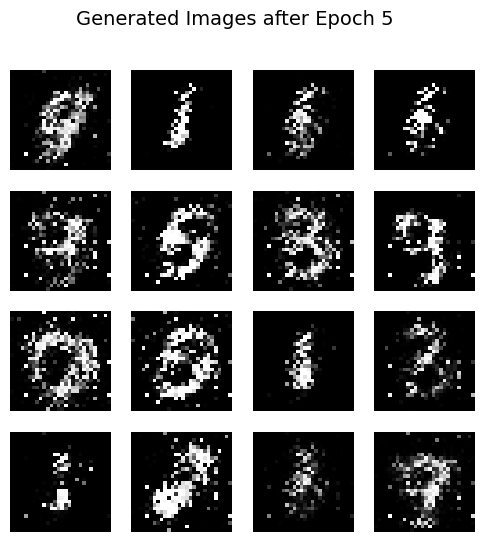

Epoch 6: D_loss=0.4811, G_loss=1.5873
Epoch 7: D_loss=0.5011, G_loss=1.2390
Epoch 8: D_loss=0.5042, G_loss=1.5615
Epoch 9: D_loss=0.6430, G_loss=1.2462
Epoch 10: D_loss=0.6296, G_loss=1.0754


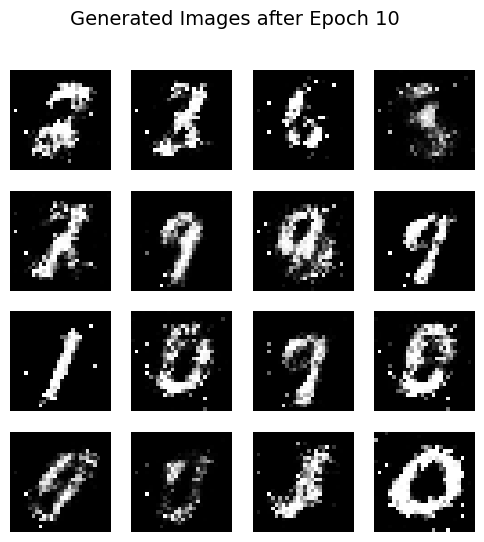

Epoch 11: D_loss=0.5668, G_loss=0.8894
Epoch 12: D_loss=0.6235, G_loss=1.3672
Epoch 13: D_loss=0.5995, G_loss=0.8385
Epoch 14: D_loss=0.5851, G_loss=0.7960
Epoch 15: D_loss=0.6142, G_loss=0.7711


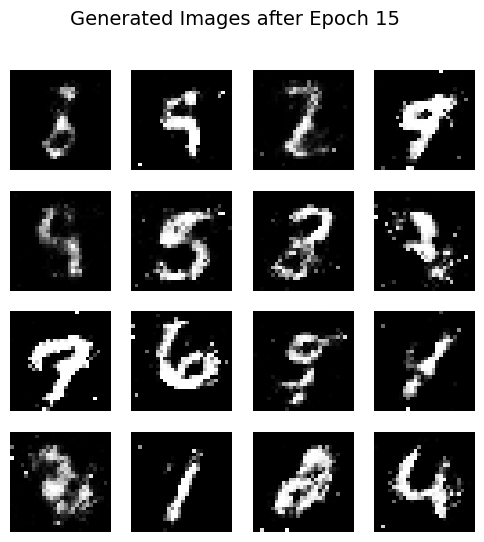

Epoch 16: D_loss=0.6854, G_loss=0.6822
Epoch 17: D_loss=0.6592, G_loss=0.7420
Epoch 18: D_loss=0.6334, G_loss=0.7064
Epoch 19: D_loss=0.6650, G_loss=0.9109
Epoch 20: D_loss=0.6434, G_loss=0.7763


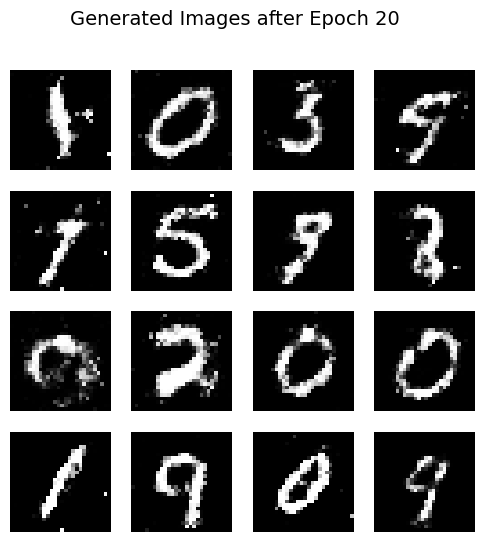

Epoch 21: D_loss=0.6827, G_loss=0.7155
Epoch 22: D_loss=0.6654, G_loss=0.8265
Epoch 23: D_loss=0.6816, G_loss=0.8638
Epoch 24: D_loss=0.6407, G_loss=0.8004
Epoch 25: D_loss=0.6732, G_loss=0.8645


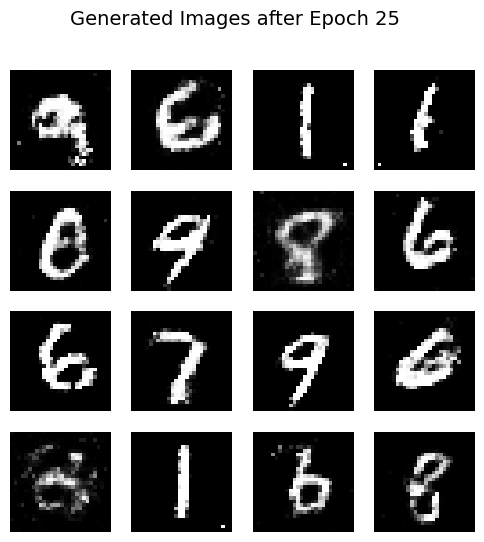

Epoch 26: D_loss=0.6493, G_loss=0.7521
Epoch 27: D_loss=0.6732, G_loss=0.5929
Epoch 28: D_loss=0.6694, G_loss=0.8316
Epoch 29: D_loss=0.6226, G_loss=0.7156
Epoch 30: D_loss=0.6477, G_loss=0.9040


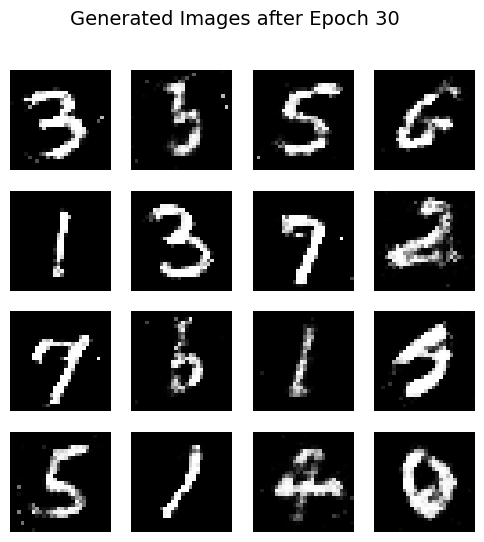

Epoch 31: D_loss=0.6285, G_loss=0.8586
Epoch 32: D_loss=0.6671, G_loss=0.9158
Epoch 33: D_loss=0.6764, G_loss=0.8562
Epoch 34: D_loss=0.6783, G_loss=0.8879
Epoch 35: D_loss=0.6575, G_loss=0.7969


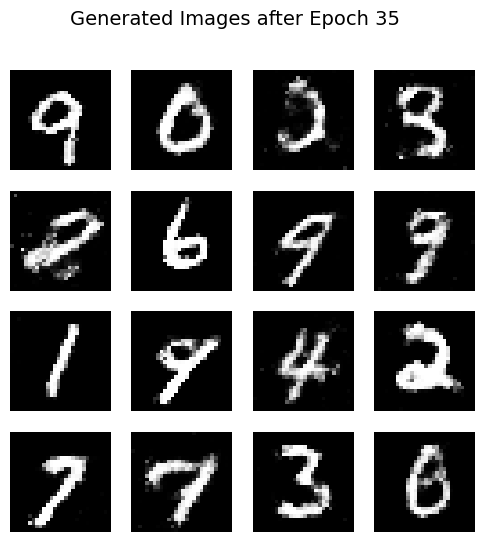

Epoch 36: D_loss=0.6647, G_loss=0.9113
Epoch 37: D_loss=0.6843, G_loss=0.8070
Epoch 38: D_loss=0.6839, G_loss=0.7067
Epoch 39: D_loss=0.6679, G_loss=0.7233
Epoch 40: D_loss=0.6581, G_loss=0.6982


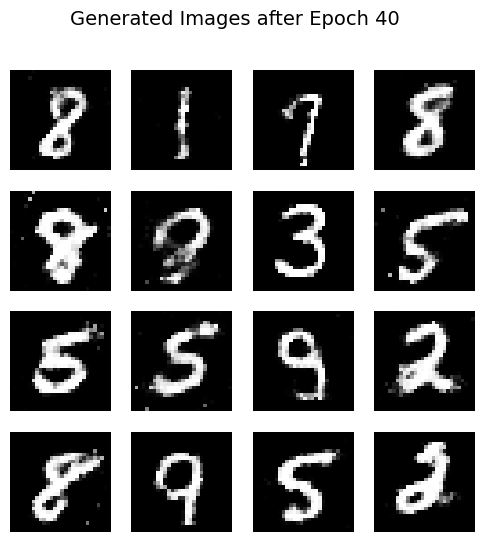

Epoch 41: D_loss=0.6470, G_loss=0.8177
Epoch 42: D_loss=0.6852, G_loss=0.8239
Epoch 43: D_loss=0.6317, G_loss=0.8335
Epoch 44: D_loss=0.6725, G_loss=0.7186
Epoch 45: D_loss=0.6845, G_loss=0.8856


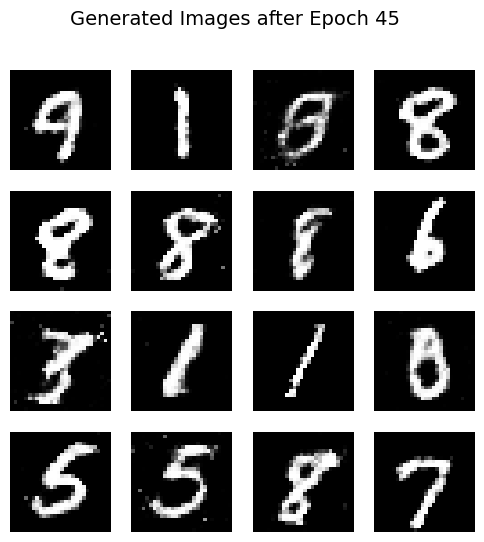

Epoch 46: D_loss=0.6785, G_loss=0.9346
Epoch 47: D_loss=0.6904, G_loss=0.7806
Epoch 48: D_loss=0.6713, G_loss=0.9335
Epoch 49: D_loss=0.6413, G_loss=0.8181
Epoch 50: D_loss=0.7068, G_loss=1.0486


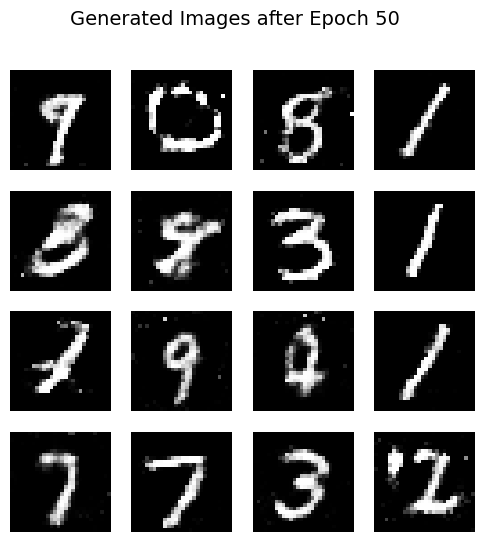

In [10]:
device = torch.device("cpu")
G = Generator(noise_dim=100).to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()
optimG = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimD = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

training()

## This approach works well enaugh, but I wanted to go back and try to make the original architecture work, so I will delete all of the changes I have made out of bias or information I found on the internet and try to stick to the architecture from the paper

So I load the data again, but do not center it around 0, instead only prepare it for Sigmoid activation

In [11]:
(trainX, _), (_, _) = mnist.load_data()
trainX = trainX.astype(np.float32) / 255.0  
trainX = trainX.reshape(-1, 28*28)           
train_tensor = torch.tensor(trainX)

train_dataset = TensorDataset(train_tensor, torch.zeros(len(train_tensor)))
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

I review the previous Generator function to include Sigmoid instead of TanH as an activation layer

In [12]:
class Generator2(nn.Module):
    def __init__(self, noise_dim=100):
        super(Generator2, self).__init__()
        self.hidden1 = nn.Linear(noise_dim, 1200)
        self.hidden2 = nn.Linear(1200, 1200)
        self.output = nn.Linear(1200, 784)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        x = self.relu(self.hidden1(z))
        x = self.relu(self.hidden2(x))
        x = self.sigmoid(self.output(x))
        return x

I use the same training set up as in the paper

In [13]:
device = torch.device("cpu")
G = Generator2(noise_dim=100).to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()
optimD = optim.SGD(D.parameters(), lr=0.1, momentum=0.5)
optimG = optim.SGD(G.parameters(), lr=0.1, momentum=0.5)

I also adjust the training funciton to use  Uniform distribution for noise sampling instead of Gaussian and using non-saturating loss for the generator as in the paper

In [14]:
def training2(real_label = 0.9, fake_label = 0.0, num_epochs = 50, batch_size = 100):
    for epoch in range(1, num_epochs + 1):
        for batch_idx, (real_images, _) in enumerate(train_loader):
            real_images = real_images.to(device)
    
            #discriminator training
            optimD.zero_grad()
            real_images_flat = real_images.view(real_images.size(0), -1)
            output_real = D(real_images_flat)
            labels_real = torch.full((real_images.size(0), 1), real_label, device=device)
            loss_real = criterion(output_real, labels_real)
    
            noise = torch.rand(real_images.size(0), 100, device=device) * 2 - 1
            fake_images = G(noise).detach()
            output_fake = D(fake_images)
            labels_fake = torch.full((real_images.size(0), 1), fake_label, device=device)
            loss_fake = criterion(output_fake, labels_fake)
    
            lossD = (loss_real + loss_fake) / 2
            lossD.backward()
            optimD.step()
    
            #generator training
            optimG.zero_grad()
            noise = torch.rand(real_images.size(0), 100, device=device) * 2 - 1
            fake_images = G(noise)
            output_fake_for_G = D(fake_images)
            labels_for_G = torch.full((real_images.size(0), 1), real_label, device=device)
            lossG = -torch.mean(torch.log(output_fake_for_G + 1e-8))
            lossG.backward()
            optimG.step()
    
        print(f"Epoch {epoch}: D_loss={lossD.item():.4f}, G_loss={lossG.item():.4f}")
    
        if epoch % 5 == 0:
            z = torch.rand(16, 100, device=device) * 2 - 1
            fake_images = G(z).view(-1, 28, 28).cpu().detach()

            fig, axes = plt.subplots(4, 4, figsize=(6, 6))
            for i, ax in enumerate(axes.flat):
                ax.imshow(fake_images[i], cmap='gray')
                ax.axis('off')
            plt.suptitle(f"Generated Images after Epoch {epoch}", fontsize=14)
            plt.show()

Epoch 1: D_loss=0.1644, G_loss=18.4207
Epoch 2: D_loss=0.1630, G_loss=18.4206
Epoch 3: D_loss=0.1762, G_loss=6.0568
Epoch 4: D_loss=0.1657, G_loss=18.4207
Epoch 5: D_loss=0.1634, G_loss=18.4206


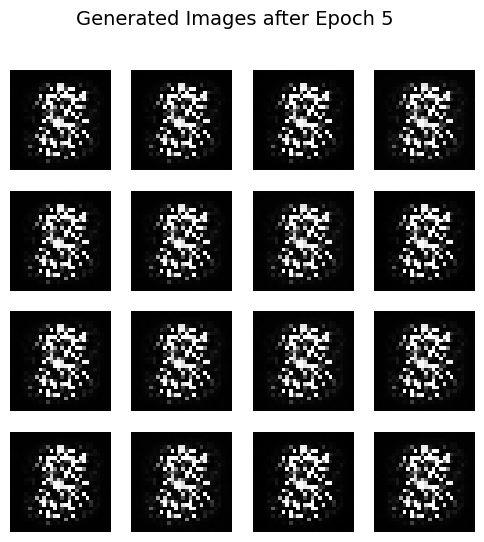

Epoch 6: D_loss=0.1867, G_loss=7.2474
Epoch 7: D_loss=0.1827, G_loss=7.5513
Epoch 8: D_loss=0.2224, G_loss=5.3300
Epoch 9: D_loss=0.1965, G_loss=4.9785
Epoch 10: D_loss=0.2298, G_loss=5.2690


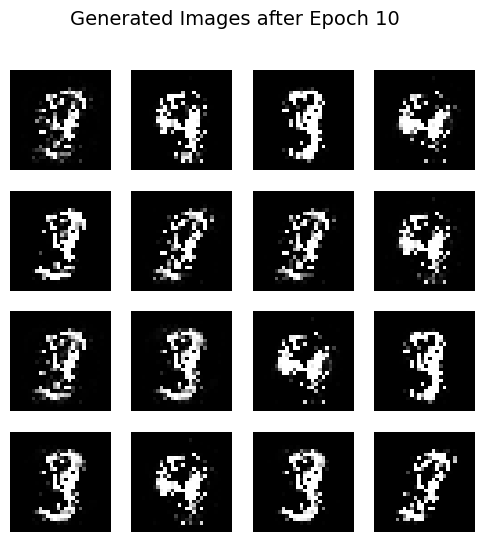

Epoch 11: D_loss=0.1759, G_loss=6.1656
Epoch 12: D_loss=0.2176, G_loss=5.8671
Epoch 13: D_loss=0.2191, G_loss=5.0923
Epoch 14: D_loss=0.2779, G_loss=3.5015
Epoch 15: D_loss=0.3556, G_loss=3.2174


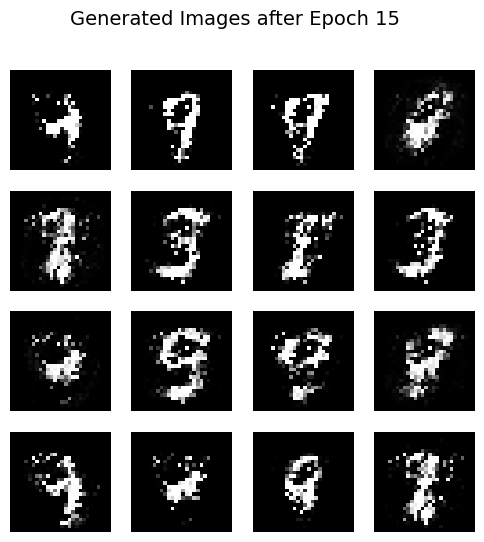

Epoch 16: D_loss=0.3212, G_loss=3.6497
Epoch 17: D_loss=0.3524, G_loss=2.7994
Epoch 18: D_loss=0.3928, G_loss=2.8751
Epoch 19: D_loss=0.4342, G_loss=1.6849
Epoch 20: D_loss=0.4065, G_loss=1.8602


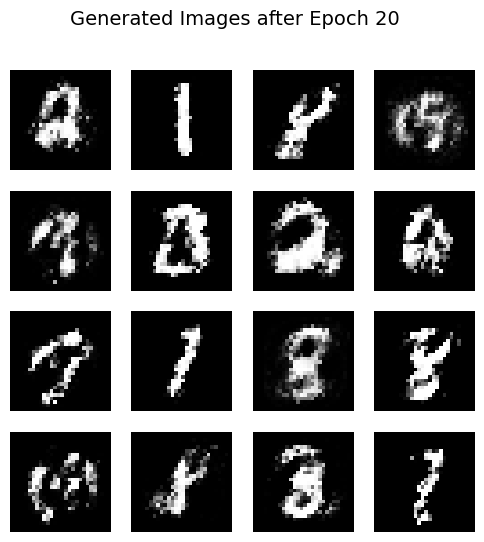

Epoch 21: D_loss=0.3702, G_loss=2.7558
Epoch 22: D_loss=0.3801, G_loss=2.4728
Epoch 23: D_loss=0.3624, G_loss=2.8659
Epoch 24: D_loss=0.3279, G_loss=2.7108
Epoch 25: D_loss=0.3940, G_loss=2.5022


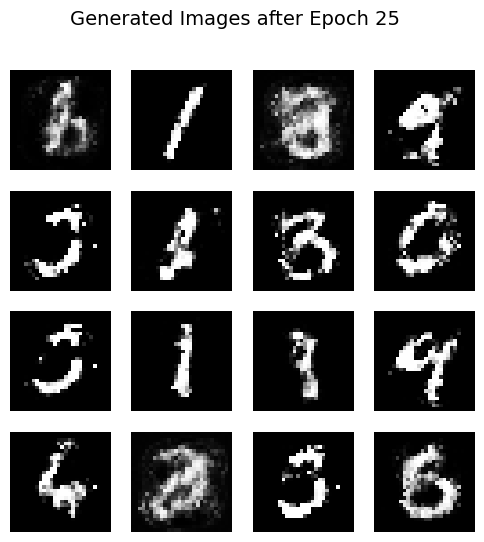

Epoch 26: D_loss=0.3721, G_loss=2.3814
Epoch 27: D_loss=0.3489, G_loss=3.0210
Epoch 28: D_loss=0.3546, G_loss=2.9272
Epoch 29: D_loss=0.3612, G_loss=2.5666
Epoch 30: D_loss=0.3719, G_loss=2.0363


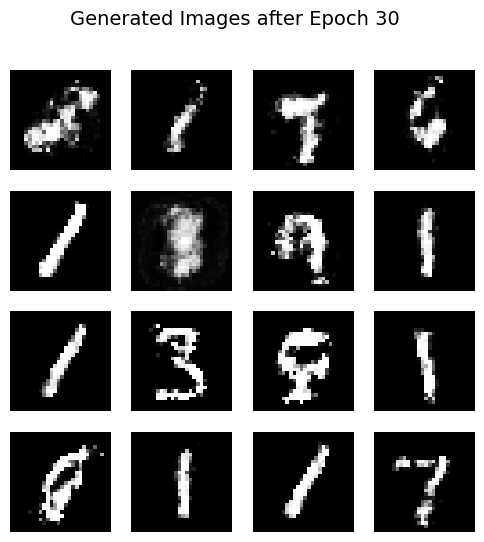

Epoch 31: D_loss=0.4005, G_loss=2.0496
Epoch 32: D_loss=0.4455, G_loss=2.5829
Epoch 33: D_loss=0.3750, G_loss=1.9249
Epoch 34: D_loss=0.4270, G_loss=2.2918
Epoch 35: D_loss=0.3207, G_loss=2.8585


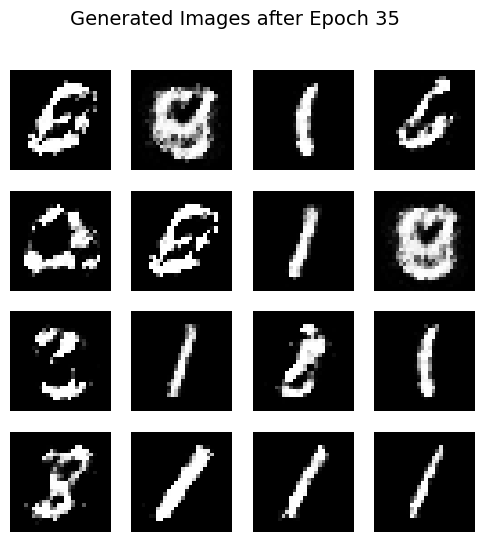

Epoch 36: D_loss=0.3775, G_loss=3.1527
Epoch 37: D_loss=0.3556, G_loss=2.5272
Epoch 38: D_loss=0.3915, G_loss=2.1559
Epoch 39: D_loss=0.3725, G_loss=2.4683
Epoch 40: D_loss=0.4395, G_loss=1.7289


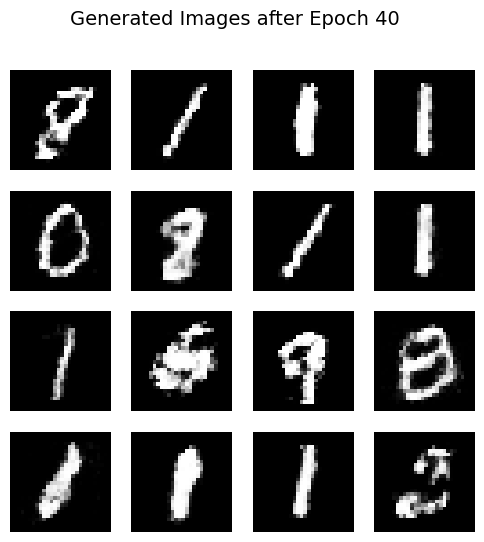

Epoch 41: D_loss=0.3610, G_loss=2.5298
Epoch 42: D_loss=0.4193, G_loss=2.2230
Epoch 43: D_loss=0.3932, G_loss=2.6474
Epoch 44: D_loss=0.3890, G_loss=2.2749
Epoch 45: D_loss=0.3722, G_loss=2.2193


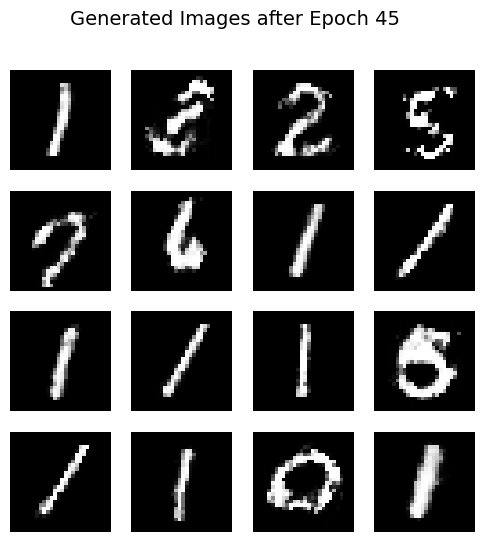

Epoch 46: D_loss=0.3699, G_loss=2.6746
Epoch 47: D_loss=0.3942, G_loss=2.5303
Epoch 48: D_loss=0.4143, G_loss=1.8192
Epoch 49: D_loss=0.4143, G_loss=2.1301
Epoch 50: D_loss=0.3549, G_loss=2.6993


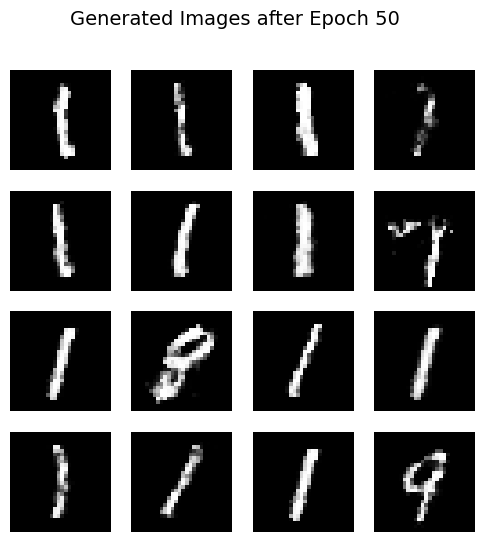

In [15]:
training2(num_epochs = 50)